# Land Cover Classification by Machine Learning Classifiers for Gibraltar Area

Author: **Marcin Sikorski**<br>
Date: July, 2024

**Introduction & Motivation**<br>
The latest years prove that the data science and remote sensing communities have begun to align due to concurrent factors. First, the development of advanced machine learning algorithms (especially deep learning) have demonstrated high performances. Second, several new Earth-observing satellites, such as Sentinel-2 and Landsat-8, were recently launched and their data provided free to the public. Finally, consumer computing power has been dramatically increasing while its cost has been decreasing (for example Google's Colab). The combination of these factors has spurred the popularity of machine learning in the remote sensing and Earth-observation communities, particularly in the sub-field of land-cover and land-use (LCLU) classification.

Tasks related to LCLU classification are basic for remote sensing. They have high usage for monitoring important changes to the environment, such as deforestation, urbanization, and agricultural expansion, occur at the scale of landscapes and directly impact ecosystem processes. Classification using satellite data provides a crucial starting point for ecosystem engineering.

The objective of this notebook is to compare the classification performance of four popular machine learning algorithms over a boreal landscape in Gibraltar using Sentinel-2 data. This will be made for unseen data. We will use satellite data from the Sentinel-2 mission launched by ESA (European Space Agency).

**Study Area**<br>
The area of study will be Gibraltar and its local regions. This British Overseas Territory and city is located at the southern tip of the Iberian Peninsula, on the Bay of Gibraltar, near the exit of the Mediterranean Sea into the Atlantic Ocean (Strait of Gibraltar). This study area was chosen due to wide variety of land cover types.

<img src=https://upload.wikimedia.org/wikipedia/commons/thumb/5/55/Gibraltar_location_in_Europe.svg/1280px-Gibraltar_location_in_Europe.svg.png width=400 height=40 />
<p style="text-align:center; font-size:12px;">Location of study area (source: Wikipedia).</p>

**Notebook Content:**
1. Importing Modules & Reading Data<br>
    1.1. Training Dataset With Training Labels<br>
    1.2. Training Dataset With Training Data<br>
    1.3. Testing Dataset<br>
2. Data Distribution of Bands
3. Vegetation Indices
4. Preprocessing Data
5. Machine Learning Classifiers<br>
    5.1. Category Boosting<br>
    5.2. Gaussian Naive Bayes<br>
    5.3. k-Nearest Neighbors<br>
    5.4. Random Forest<br>
    5.5. Classifier Comparison<br>
6. Conclusions

### 1. Importing Modules & Reading Data

At this stage, we will import three GeoTIFF rasters. Sentinel-2 images carry the Multispectral Imager (MSI) and are open-source. They also have relatively high spatial resolution with 10 m and 3x3 degree tiling grid. This makes the Sentinel-2 data appealing for LCLU mapping. The ground truth has eight classes. The satellite images can be downloaded from the [ESA website](https://worldcover2021.esa.int/download).

In [1]:
import numpy as np
import pandas as pd
from osgeo import gdal, osr
import matplotlib.pyplot as plt

**1.1. Training Dataset With Training Labels**

This raster provides basic information and metadata needed to perform LULC classification. Each image pixel represents a specific class (training label). This image contains only one band. The main purpose of this raster is to extract the labels for classifying. The coding of the map layers are posted in this [manual, p. 15](https://esa-worldcover.s3.eu-central-1.amazonaws.com/v200/2021/docs/WorldCover_PUM_V2.0.pdf#page=15).

In [2]:
# open the GeoTIFF files using GDAL
ds_training_GT = gdal.Open('S2A_MSIL1C_20220516_Train_GT.tif', gdal.GA_ReadOnly)

# read the data from the first GeoTIFF file into a NumPy array
train_GT_2d = ds_training_GT.ReadAsArray()
train_GT_2d = np.swapaxes(train_GT_2d, 0, 1)

# convert the 2D NumPy arrays into 2D arrays with rows and columns
train_GT_1d = train_GT_2d.reshape(train_GT_2d.shape[0] * train_GT_2d.shape[1], 1)

# convert the combined array into a Pandas dataframe
df_train_labels = pd.DataFrame(train_GT_1d)

# image size
count = ds_training_GT.RasterCount
img_width, img_height = ds_training_GT.RasterXSize, ds_training_GT.RasterYSize
crs = ds_training_GT.GetMetadataItem('product_crs')

print(f'Number of bands: {count}\nHeight: {img_height}\nWidth: {img_width}\nCRS: {crs}')

Number of bands: 1
Height: 1131
Width: 855
CRS: EPSG:4326


Height: 1131
Width: 855
Data type: 1
Min/max values: (10.0, 90.0)
Min/max/mean/std values: [10.0, 90.0, 64.28229816205446, 23.099381472974393]


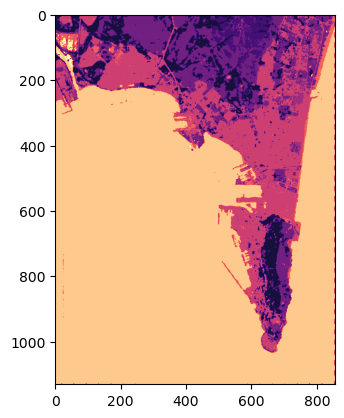

In [3]:
# band information
band = ds_training_GT.GetRasterBand(1)

print(f'Height: {band.YSize}\nWidth: {band.XSize}\nData type: {band.DataType}')
print(f'Min/max values: {band.ComputeRasterMinMax()}')
print(f'Min/max/mean/std values: {band.ComputeStatistics(0)}')

# plot image
band_array = band.ReadAsArray()
plt.imshow(band_array, cmap='magma')
plt.show()

In [4]:
# projection information from WKT
proj = osr.SpatialReference(wkt=ds_training_GT.GetProjectionRef())

print('EPSG:', proj.GetAttrValue('AUTHORITY', 1))
print('Zone:', proj.GetAttrValue('PROJCS', 0))

EPSG: 32630
Zone: WGS 84 / UTM zone 30N


In [5]:
# raster metadata
ds_training_GT.GetMetadata()

{'algorithm_version': 'V2.0.0',
 'AREA_OR_POINT': 'Area',
 'copyright': 'ESA WorldCover project 2021 / Contains modified Copernicus Sentinel data (2021) processed by ESA WorldCover consortium',
 'creation_time': '2022-10-21 07:35:40.236136',
 'legend': '10  Tree cover\n20  Shrubland\n30  Grassland\n40  Cropland\n50  Built-up\n60  Bare/sparse vegetation\n70  Snow and ice\n80  Permanent water bodies\n90  Herbaceous wetland\n95  Mangroves\n100 Moss and lichen\n',
 'license': 'CC-BY 4.0 - https://creativecommons.org/licenses/by/4.0/',
 'product_crs': 'EPSG:4326',
 'product_grid': '3x3 degree tiling grid',
 'product_tile': 'N36W006',
 'product_type': 'LandCover Map',
 'product_version': 'V2.0.0',
 'reference': 'https://esa-worldcover.org',
 'time_end': '2021-12-31T23:59:59Z',
 'time_start': '2021-01-01T00:00:00Z',
 'title': 'ESA WorldCover product at 10m resolution for year 2021'}

To extract the range coordinates of the raster, we will use the geotransform which is an affine transformation from the image coordinate space (row, column), also known as (pixel, line) to the georeferenced coordinate space (projected or geographic coordinates). The formulas for the coordinates are:

$$X_{geo} = GT(0) + X_{pixel} \times GT(1) + Y_{line} \times GT(2)$$

$$Y_{geo} = GT(3) + X_{pixel} \times GT(4) + Y_{line} \times GT(5)$$


In case of north up images:<br>
GT(2), GT(4) coefficients are zero;<br>
GT(1), GT(5) is the pixel size;<br>
GT(0), GT(3) position is the top left corner of the top left pixel of the raster.

In [6]:
'''
A geotransform consists in a set of 6 coefficients:
GT(0) x-coordinate of the upper-left corner of the upper-left pixel,
GT(1) w-e pixel resolution / pixel width,
GT(2) row rotation (typically zero),
GT(3) y-coordinate of the upper-left corner of the upper-left pixel,
GT(4) column rotation (typically zero),
GT(5) n-s pixel resolution / pixel height (negative value for a north-up image).
'''

GT = ds_training_GT.GetGeoTransform()

minx = GT[0]
miny = GT[3] + img_width * GT[4] + img_height * GT[5]
maxx = GT[0] + img_width * GT[1] + img_height * GT[2]
maxy = GT[3]

print(f'X min: {minx}\nY min: {miny}\nX max: {maxx}\nY max: {maxy}')

X min: 282160.0
Y min: 3997630.0
X max: 290710.0
Y max: 4008940.0


**1.2. Training Dataset With Training Data**

This satellite image will be used for training our classifying models. The GeoTIFF file contains four band channels: blue, green, red, NIR. Each image pixel's color is defined by the bands and will be used as classifying attributes assigned to each class.

In [7]:
ds_training = gdal.Open('S2A_MSIL1C_20220516_TrainingData.tif', gdal.GA_ReadOnly)

# read the data from the first GeoTIFF file into a NumPy array
data_training = ds_training.ReadAsArray()
data_training = np.swapaxes(data_training, 0, 2)

# convert the 2D NumPy arrays into 2D with rows and columns
data_training_1d = data_training.reshape(data_training.shape[0] * data_training.shape[1], -1)
df_train = pd.DataFrame(data_training_1d)

# create dataframe
final_data = pd.concat([df_train_labels, df_train])
train_label_data = pd.concat([df_train_labels, df_train], axis=1)
train_label_data.columns = ['Class', 'Blue', 'Green', 'Red', 'NIR']

# export dataframe to CSV file
#train_label_data.to_csv('train.csv', index=False)

# image size
count = ds_training.RasterCount
img_width, img_height = ds_training.RasterXSize, ds_training.RasterYSize

print(f'Number of bands: {count}\nHeight: {img_height}\nWidth: {img_width}')

Number of bands: 4
Height: 1131
Width: 855


Band-1
Min/max/mean/std values: [0.0, 10915.0, 2420.217324626036, 346.7068223591508]
Band-2
Min/max/mean/std values: [0.0, 11377.0, 2284.0169678543543, 402.35624265696106]
Band-3
Min/max/mean/std values: [0.0, 14103.0, 2233.2282790678437, 567.2224603639628]
Band-4
Min/max/mean/std values: [0.0, 15343.0, 2602.8054694649977, 887.3425007801084]


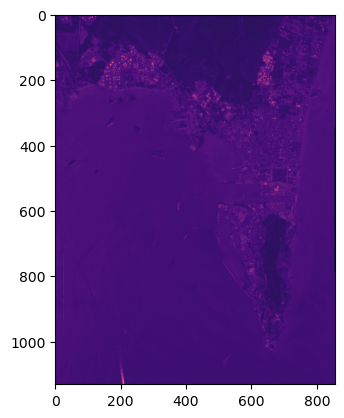

In [8]:
# information of each band
for i in range(1, 5):
    band = ds_training.GetRasterBand(i)
    print(f'Band-{i}')
    print(f'Min/max/mean/std values: {band.ComputeStatistics(0)}')
    
# plot image
band = ds_training.GetRasterBand(1)
band_array = band.ReadAsArray()
plt.imshow(band_array, cmap='magma')
plt.show()

**1.3. Testing Dataset**

This aerial image will be used for validating our classifying models. Notice it has much higher resolution and contains the training dataset within it. The prediction will be performed on unseen data by using a limited number of training samples. This raster also contains the previous four band channels, but not the labels. The labels will be predicted for this raster based on the band data in each pixel.

In [9]:
ds_testing = gdal.Open('S2B_MSIL1C_20220528_Test.tif', gdal.GA_ReadOnly)

# read the data from the first GeoTIFF file into a NumPy array
data_testing = ds_testing.ReadAsArray()
data_testing = np.swapaxes(data_testing, 0, 2)

# convert the 2D NumPy arrays into 2D arrays with rows and columns
data_testing_1d = data_testing.reshape(data_testing.shape[0] * data_testing.shape[1], -1)

# convert the combined array into a Pandas dataframe
df_test = pd.DataFrame(data_testing_1d, columns=['Blue', 'Green', 'Red', 'NIR'])

# export dataframe to CSV file
#df_test.to_csv('test.csv', index=False)

# image size
count = ds_testing.RasterCount
img_width, img_height = ds_testing.RasterXSize, ds_testing.RasterYSize

print(f'Number of bands: {count}\nHeight: {img_height}\nWidth: {img_width}')

Number of bands: 4
Height: 2001
Width: 2309


Band-1
Min/max/mean/std values: [0.0, 6747.0, 2134.583164459347, 315.2055007969227]
Band-2
Min/max/mean/std values: [0.0, 7127.0, 2061.257802670774, 411.6259118311492]
Band-3
Min/max/mean/std values: [0.0, 7874.0, 1920.5451579104342, 581.5019821553493]
Band-4
Min/max/mean/std values: [0.0, 7938.0, 3241.4306090783107, 1305.0949455862235]


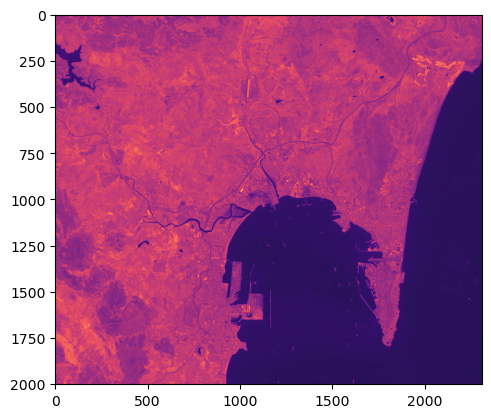

In [10]:
# information of each band
for i in range(1, 5):
    band = ds_testing.GetRasterBand(i)
    print(f'Band-{i}')
    print(f'Min/max/mean/std values: {band.ComputeStatistics(0)}')
    
# plot image
band = ds_testing.GetRasterBand(4)
band_array = band.ReadAsArray()
plt.imshow(band_array, cmap='magma')
plt.show()

### 2. Data Distribution of Bands

We will plot distributions of pixel values and explore the image bands. We will check the quantitative data of labels to predict in the testing raster.

In [11]:
import earthpy.plot as ep
import earthpy as et
import earthpy.spatial as es

#pip install pyrsgis
from pyrsgis import raster

In [12]:
data = 'S2A_MSIL1C_20220516_TrainingData.tif'
labels = 'S2A_MSIL1C_20220516_Train_GT.tif'

# train data contains bands, test data contains labels
ds1, features_train = raster.read(data, bands='all')
ds2, features_test = raster.read(labels, bands ='all')

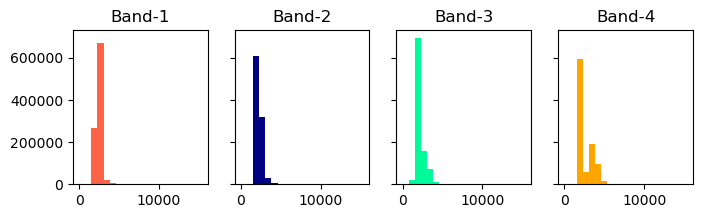

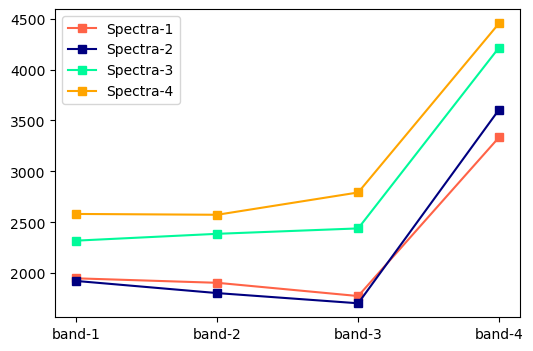

In [13]:
colors = ['tomato', 'navy', 'MediumSpringGreen', 'orange']

# histograms for each band
ep.hist(features_train, cols=4, colors=colors, title=[f'Band-{i}' for i in range(1, 5)], figsize=(8, 2))
plt.show()

# plot spectra for 3rd row
plt.figure(figsize=(6, 4))
for i, c in enumerate(colors):
    plt.plot(np.asarray(features_train[:, 2, i]), '-s', color=c, label= f'Spectra-{i+1}')
plt.xticks(range(4), [f'band-{i}' for i in range(1, 5)])
plt.legend()
plt.show()

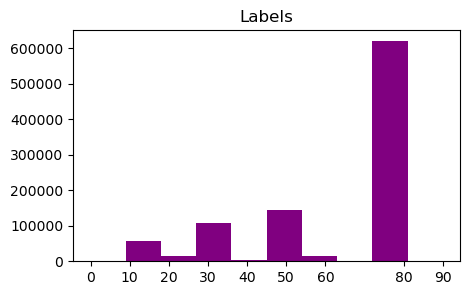

In [14]:
# histogram for class distribution
bins = len(np.unique(features_test))

ep.hist(features_test, title='Labels', bins=bins+1, figsize=(5, 3))
plt.xticks(np.unique(features_test).tolist())
plt.show()

In [15]:
classes, counts = np.unique(features_test, return_counts=True)

# class: 0 - undefined
pd.DataFrame(data={'Class': classes, 'Pixel Count': counts}).style.hide(axis='index')

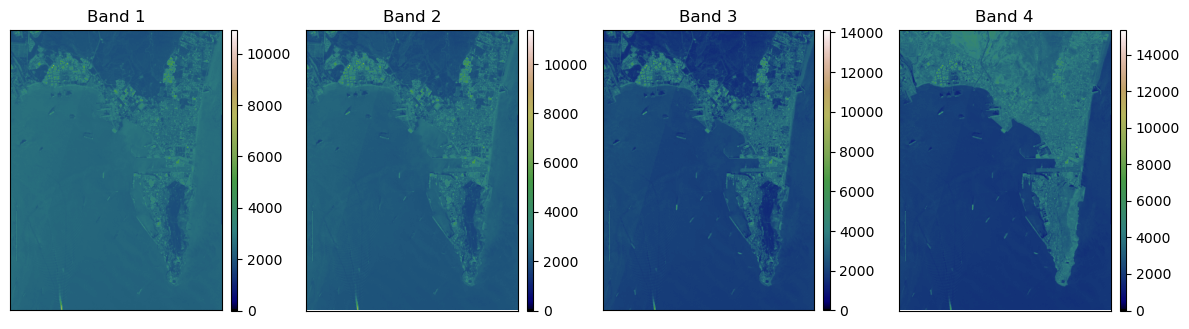

In [16]:
# plot each band
ep.plot_bands(features_train, cmap='gist_earth', cols=4)
plt.show()

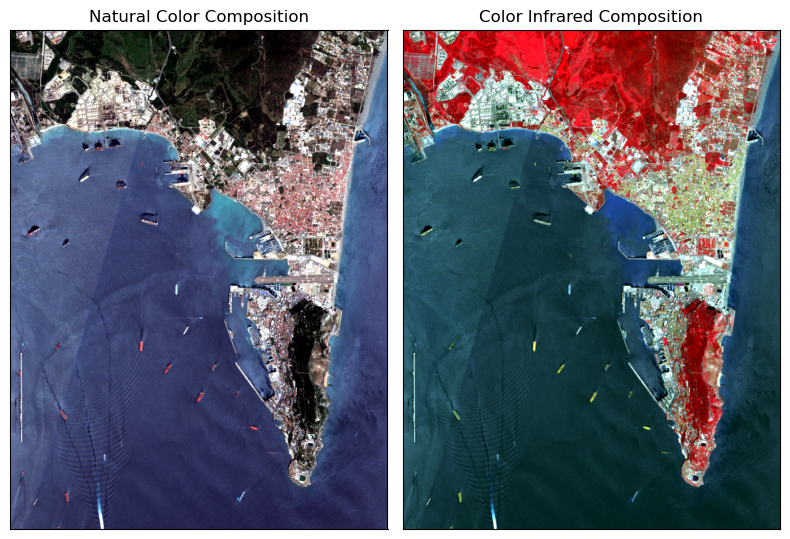

In [17]:
# band combinations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 7))

# natural color (red, green, blue)
ax1 = ep.plot_rgb(features_train, rgb=(2, 1, 0), ax=ax1, stretch=True, title='Natural Color Composition')

# color infrared (NIR, red, green)
ax2 = ep.plot_rgb(features_train, rgb=(3, 2, 1), ax=ax2, stretch=True, title='Color Infrared Composition')

plt.tight_layout()
plt.show()

### 3. Vegetation Indices

Vegetation index is a spectral imaging transformation of two or more image bands developed to enhance the contribution of vegetation properties and allow reliable spatial and temporal inter-comparisons of terrestrial photosynthetic activity and canopy structural variations.<br>
Examples of usage:
* monitoring level of moisture stress in leaves,
* classifying vegetation dynamics,
* monitoring drought,
* scheduling crop irrigation and crop management,
* detecting crop deseases,
* monitoring evaporation and plant transpiration.

**Normalized Difference Vegetation Index** - most commonly used remote sensing index; used for qualifying the health, dynamics and density of vegetation.

$$NDVI = \frac{NIR - Red}{NIR + Red}$$

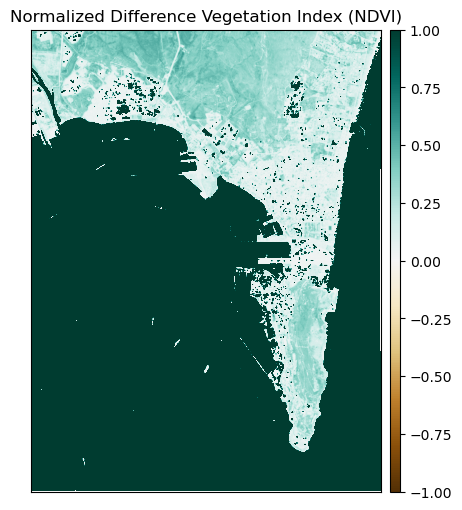

In [18]:
ndvi = (features_train[3] - features_train[2])/(features_train[3] + features_train[2])

title = 'Normalized Difference Vegetation Index (NDVI)'
ep.plot_bands(ndvi, cmap='BrBG', title=title, vmin=-1, vmax=1, figsize=(6, 6))

plt.show()

**Vegetation Condition Index** - derived from NVDI for range [0, 1] (or [0%, 100%]); used for observing vegetation state conditions and monitoring health and conditions of crops over time.

$$VCI = \frac{NVDI - NVDI_{min}}{NVDI_{max} + NVDI_{min}}$$

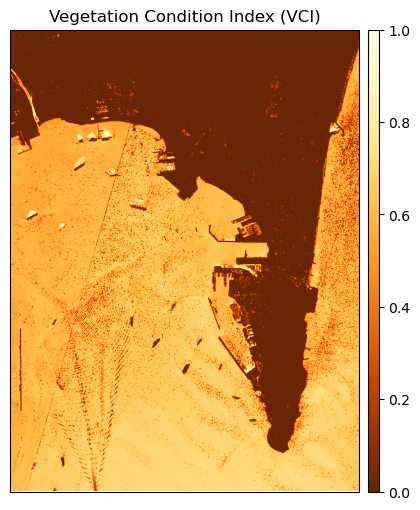

In [19]:
vci = (ndvi - np.nanmin(ndvi))/(np.nanmax(ndvi) - np.nanmin(ndvi))

title = 'Vegetation Condition Index (VCI)'
ep.plot_bands(vci, cmap='YlOrBr_r', title=title, vmin=0, vmax=1, figsize=(6, 6))

plt.show()

**Optimized Soil Adjusted Vegetation Index (OSAVI)** - used to assess the abundance and vigor of vegetation in an area.

$$OSAVI = 1.6 \frac{NIR - Red}{NIR + Red + 0.16}$$

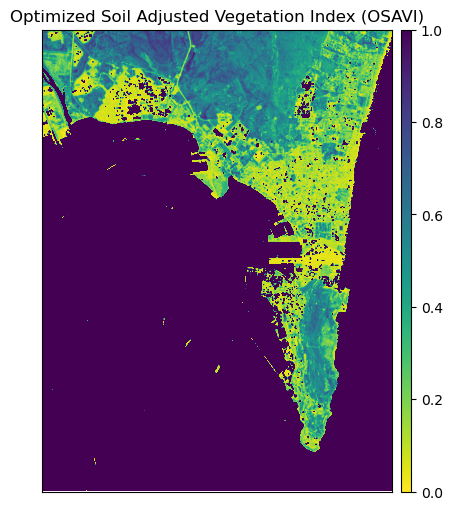

In [20]:
osavi = 1.6 * ((features_train[3] - features_train[2])/((features_train[3] + features_train[2]) + 0.16))

title = 'Optimized Soil Adjusted Vegetation Index (OSAVI)'
ep.plot_bands(osavi, cmap='viridis_r', vmin=0, vmax=1, title=title, figsize=(6, 6))

plt.show()

**Normalized Difference Water Index** - used to detect and highlight open water features in a satellite image. Also applied for monitoring drought stress in crops.

$$NDWI = \frac{Green - NIR}{Green + NIR}$$

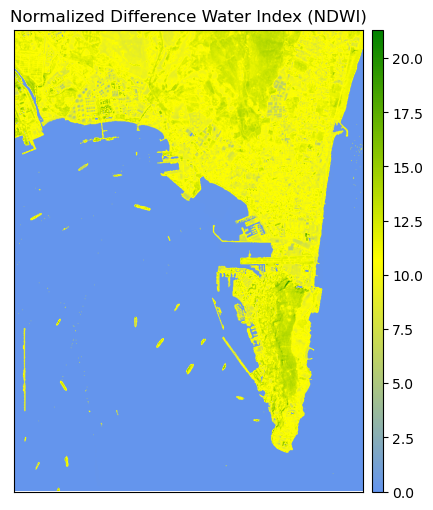

In [21]:
from matplotlib.colors import LinearSegmentedColormap

ndwi = (features_train[1] - features_train[3])/(features_train[1] + features_train[3])

norm = plt.Normalize(0, 1)
cmap = LinearSegmentedColormap.from_list('', ['cornflowerblue', 'yellow', 'green'])

title = 'Normalized Difference Water Index (NDWI)'
ep.plot_bands(ndwi, cmap=cmap, vmin=0, title=title, figsize=(6, 6))

plt.show()

**Transformed Vegetation Index** - modified version of NDVI to avoid operating with negative NDVI values.

$$TVI = \sqrt{NDVI + 0.5} = \sqrt{\frac{NIR - Red}{NIR + Red} + 0.5}$$

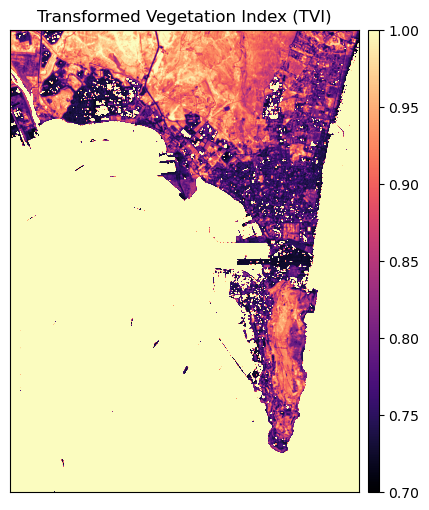

In [22]:
tvi = ((features_train[3] - features_train[2])/(features_train[3] + features_train[2]) + 0.5)**0.5

title = 'Transformed Vegetation Index (TVI)'
ep.plot_bands(tvi, cmap='magma', vmin=0.7, vmax=1, title=title, figsize=(6, 6))

plt.show()

### 4. Preprocessing Data

At this stage the data will be perpared for classifying. These steps will be applied before developing the models:
* rename and set training and testing datasets,
* drop rows with unidentified class in the training dataset - assigned as zero,
* transform features by scaling each band to range [0, 1],
* divide datasets into train and test sets with 70:30 ratio.

Lastly, a dataframe will be created to store information about land cover classes and their color coding. This will be helpful for filtering data by class numbers to extract colors and land cover.

In [23]:
# reaname variables
train = train_label_data
test = df_test
del train_label_data, df_test

# optionally: load dataframes from CSV files
#train = pd.read_csv('train.csv')
#test = pd.read_csv('test.csv')

train.head()

Class  Blue  Green   Red   NIR
0     10     0      0     0     0
1     10  1997   1982  1860  3672
2     10  1950   1906  1776  3335
3     10  1933   1886  1742  3390
4     10  2162   2035  2173  3605

In [24]:
# drop unknown classes
train = train[train['Class'] != 0]

In [25]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# rescale features
scaled_train = pd.DataFrame(MinMaxScaler().fit_transform(train), columns=train.columns)
scaled_test =  pd.DataFrame(MinMaxScaler().fit_transform(test), columns=test.columns)

X = np.array(train.drop('Class', axis=1)[::10])
y = np.array(train['Class'][::10])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

print(f'Training rows: {X_train.shape[0]}\nTesting rows: {X_test.shape[0]}')

Training rows: 67591
Testing rows: 28968


In [26]:
# class number: class name
legend_desc = ds_training_GT.GetMetadataItem('legend')
print(f'{legend_desc}')

10  Tree cover
20  Shrubland
30  Grassland
40  Cropland
50  Built-up
60  Bare/sparse vegetation
70  Snow and ice
80  Permanent water bodies
90  Herbaceous wetland
95  Mangroves
100 Moss and lichen



In [27]:
# all available labels in training dataset
classes = np.unique(train['Class']).tolist()
classes

[10, 20, 30, 40, 50, 60, 80, 90]

In [28]:
# notice label 70 (Snow and ice) is missing in the training dataset
cover_labels = ['Tree cover',               # 10
                'Shrubland',                # 20
                'Grassland',                # 30
                'Cropland',                 # 40
                'Built-up',                 # 50
                'Bare/sparse vegetation',   # 60
                #'Snow and ice'              # 70
                'Water bodies',             # 80
                'Herbaceous wetland'        # 90
               ]

# function for RGB -> HEX conversion
def hextriplet(colortuple):
    return '#' + ''.join(f'{i:02X}' for i in colortuple)

# RGB colors used in ESA manual
rgb_list = [(0,100,0),     # 10
            (255,187,34),  # 20
            (255,255,76),  # 30
            (240,150,255), # 40
            (250,0,0),     # 50
            (180,180,180), # 60
            #(240,240,240), # 70
            (0,100,200),   # 80
            (0,150,160)    # 90
           ]

# convert RGB colors to HEX codes
cover_colors = []
for i in rgb_list:
    cover_colors.append(hextriplet(i))
    
# store attributes in dataframe
df_esa = pd.DataFrame(data=zip(classes, cover_labels, cover_colors, rgb_list),
                      columns=['Class', 'Cover', 'Hex', 'RGB'])

df_esa.style.hide(axis='index')

### 5. Machine Learning Classifiers

To develop the models, we will implement four different algorithms. Each classifier will be preceded with hyperparameter tuning to obtain the optimum arguments. Next, we will plot learning curves to monitor the learning process for different training set sizes. By default it determines cross-validated training and test scores for different set sizes. Afterwards, the classifiers will perform the final predictions, plot the results, and display classification reports. As evaluation metrics we will take in account accuracy and Kappa coefficient. We will plot predictions with color maps according to the guidelines in ESA user manual.

In [29]:
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

import sklearn.metrics as metrics
from sklearn.model_selection import learning_curve

**5.1. Category Boosting**

In [30]:
# hyperparameter tuning
depths = [6, 8, 10]
learning_rates = [0.05, 0.1]

cb_scores = []

for depth in depths:
    for rate in learning_rates:
        cb = CatBoostClassifier(depth=depth, learning_rate=rate)
        cb.fit(X_train, y_train, verbose=False)
        cb_pred = cb.predict(X_test)
        
        cb_scores.append({'accuracy': metrics.accuracy_score(y_test, cb_pred),
                          'depth': depth,
                          'learning_rate': rate,
                         })

# get optimum hyperparameters
accuracies = [result['accuracy'] for result in cb_scores]
cb_idx = accuracies.index(max(accuracies))

print('Best score:', cb_scores[cb_idx])

Best score: {'accuracy': 0.904895056614195, 'depth': 8, 'learning_rate': 0.1}


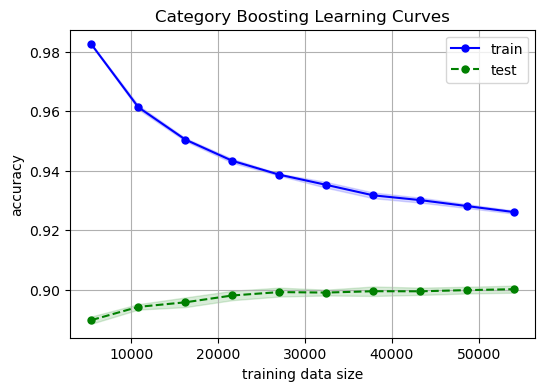

In [31]:
# generate different set sizes and get scores
train_sizes, train_scores, test_scores = learning_curve(CatBoostClassifier(depth=8, learning_rate=0.1, verbose=False),
                                                        X_train, y_train,
                                                        train_sizes=np.linspace(0.1, 1.0, 10)
                                                       )

# function for plotting learning curves
def plot_learning_curves(clf):
    # calculate training and testing mean and std
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    # plot learning curves
    plt.figure(figsize=(6, 4))
    
    plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='train')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
    plt.plot(train_sizes, test_mean, color='green', marker='o', markersize=5, linestyle='--', label='test')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
    plt.title(f'{clf} Learning Curves')
    plt.xlabel('training data size')
    plt.ylabel('accuracy')
    plt.grid()
    plt.legend()
    plt.show()
    
plot_learning_curves(clf='Category Boosting')

In [32]:
cb = CatBoostClassifier(depth=8, learning_rate=0.1)
cb.fit(X_train, y_train, verbose=False)
cb_pred = cb.predict(X_test)

# make predictions
y_pred_cb = cb.predict(test)

# evaluation metrics
acc_cb = metrics.accuracy_score(y_test, cb_pred)
kappa_cb = metrics.cohen_kappa_score(y_test, cb_pred)

print("Accuracy: {:0.4f}\nCohen's kappa: {:0.4f}".format(acc_cb, kappa_cb))

Accuracy: 0.9049
Cohen's kappa: 0.8258


In [33]:
# extract predicted classes, colors, covers
cb_classes = np.unique(y_pred_cb).tolist()
cb_colors = df_esa.query(f'Class in {cb_classes}')['Hex'].tolist()
cb_covers = df_esa.query(f'Class in {cb_classes}')['Cover'].tolist()

# new array made of assigned color indices to predicted labels
cb_func = np.vectorize(lambda x: cb_classes.index(x))
cb_data = cb_func(y_pred_cb)

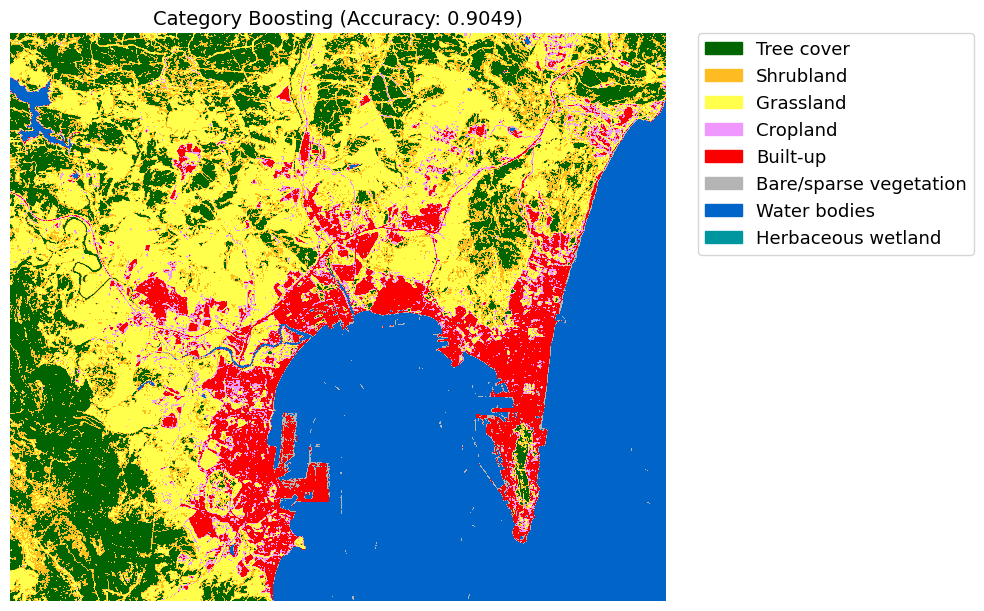

In [34]:
from matplotlib.colors import ListedColormap

cb_cmap = ListedColormap(cb_colors)

height = ds_testing.ReadAsArray().shape[2]
width = ds_testing.ReadAsArray().shape[1]

# plot predicted data
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(cb_data.reshape(height, width).T, cmap=cb_cmap, vmin=0, vmax=len(cb_colors)-1)

ep.draw_legend(im_ax=im, classes=cb_classes, titles=cb_covers)
#ax.set_title('Category Boosting (Accuracy: {:.2f}%)'.format(acc_cb*100), fontsize=14)
ax.set_title('Category Boosting (Accuracy: {:.4f})'.format(acc_cb), fontsize=14)
ax.set_axis_off()

# auto adjust plot to fit figure size
plt.tight_layout()
plt.show()

In [35]:
print(metrics.classification_report(y_test, cb_pred, target_names=cover_labels))

                        precision    recall  f1-score   support

            Tree cover       0.76      0.62      0.68      1801
             Shrubland       0.60      0.56      0.58       462
             Grassland       0.70      0.75      0.72      3173
              Cropland       0.45      0.11      0.17       120
              Built-up       0.79      0.90      0.84      4296
Bare/sparse vegetation       0.70      0.24      0.36       422
          Water bodies       0.99      0.99      0.99     18646
    Herbaceous wetland       0.33      0.10      0.16        48

              accuracy                           0.90     28968
             macro avg       0.67      0.53      0.56     28968
          weighted avg       0.90      0.90      0.90     28968



**5.2. Gaussian Naive Bayes**

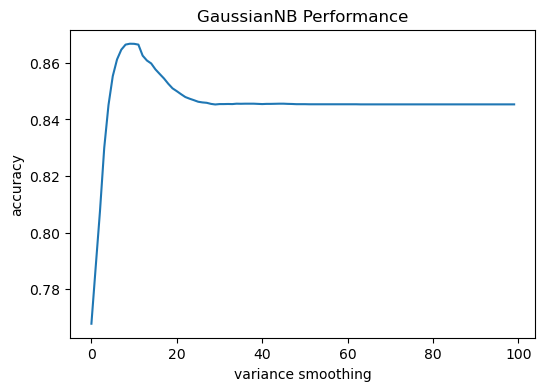

Score: 0.8668 for variance = 0.15199110829529336


In [36]:
# hyperparameter tuning
variances = np.logspace(0, -9, num=100)

nb_scores = []

for var in variances:
    nb = GaussianNB(var_smoothing=var)
    nb.fit(X_train, y_train)
    nb_pred = nb.predict(X_test)
    
    nb_scores.append(metrics.accuracy_score(y_test, nb_pred))

# get optimum variance
var_idx = nb_scores.index(max(nb_scores))
var = variances[var_idx]

# plot results
plt.figure(figsize=(6, 4))   
plt.plot(nb_scores)
plt.title('GaussianNB Performance')
plt.xlabel('variance smoothing')
plt.ylabel('accuracy')
#plt.grid()
plt.show()

print('Score: {:0.4f} for variance = {}'.format(max(nb_scores), var))

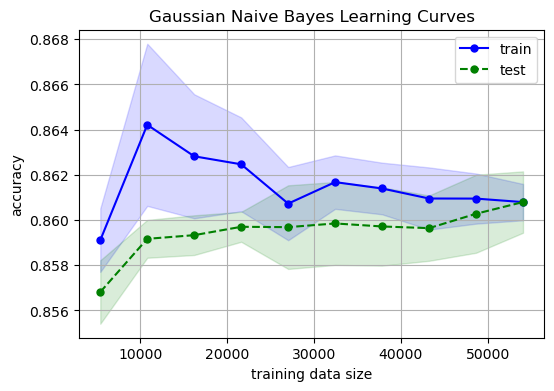

In [37]:
# generate different set sizes and get scores
train_sizes, train_scores, test_scores = learning_curve(GaussianNB(var_smoothing=0.15199110829529336),
                                                        X_train, y_train,
                                                        train_sizes=np.linspace(0.1, 1.0, 10)
                                                       )

plot_learning_curves(clf='Gaussian Naive Bayes')

In [38]:
nb = GaussianNB(var_smoothing=0.15199110829529336)
nb.fit(X_train, y_train)
nb_pred = nb.predict(X_test)

# make predictions
y_pred_nb = nb.predict(test)

# evaluation metrics
acc_nb = metrics.accuracy_score(y_test, nb_pred)
kappa_nb = metrics.cohen_kappa_score(y_test, nb_pred)

print("Accuracy: {:0.4f}\nCohen's kappa: {:0.4f}".format(acc_nb, kappa_nb))

Accuracy: 0.8668
Cohen's kappa: 0.7514


In [39]:
# extract predicted classes, colors, covers
nb_classes = np.unique(y_pred_nb).tolist()
nb_colors = df_esa.query(f'Class in {nb_classes}')['Hex'].tolist()
nb_covers = df_esa.query(f'Class in {nb_classes}')['Cover'].tolist()

# new array made of assigned color indices to predicted labels
nb_func = np.vectorize(lambda x: nb_classes.index(x))
nb_data = nb_func(y_pred_nb)

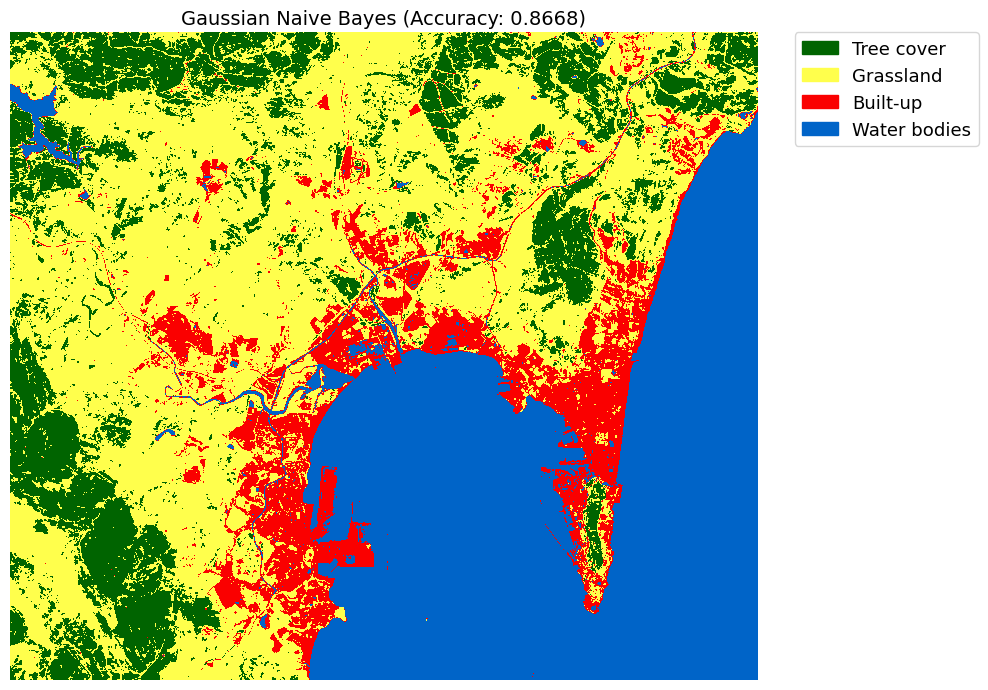

In [40]:
nb_cmap = ListedColormap(nb_colors)

height = ds_testing.ReadAsArray().shape[2]
width = ds_testing.ReadAsArray().shape[1]

# plot predicted data
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(nb_data.reshape(height, width).T, cmap=nb_cmap, vmin=0, vmax=len(nb_colors)-1)

ep.draw_legend(im_ax=im, classes=nb_classes, titles=nb_covers)
#ax.set_title('Gaussian Naive Bayes (Accuracy: {:.2f}%)'.format(acc_nb*100), fontsize=14)
ax.set_title('Gaussian Naive Bayes (Accuracy: {:.4f})'.format(acc_nb), fontsize=14)
ax.set_axis_off()

# auto adjust plot to fit figure size
plt.tight_layout()
plt.show()

In [41]:
print(metrics.classification_report(y_test, nb_pred, target_names=cover_labels))

                        precision    recall  f1-score   support

            Tree cover       0.52      0.78      0.63      1801
             Shrubland       0.00      0.00      0.00       462
             Grassland       0.66      0.62      0.64      3173
              Cropland       0.00      0.00      0.00       120
              Built-up       0.79      0.75      0.77      4296
Bare/sparse vegetation       0.00      0.00      0.00       422
          Water bodies       0.96      0.99      0.98     18646
    Herbaceous wetland       0.00      0.00      0.00        48

              accuracy                           0.87     28968
             macro avg       0.37      0.39      0.38     28968
          weighted avg       0.84      0.87      0.85     28968



**5.3. k-Nearest Neighbors**

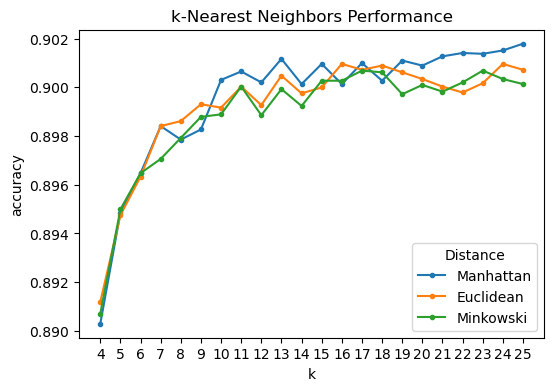

Manhattan: 0.9018 for k = 25
Euclidean: 0.9010 for k = 16
Minkowski: 0.9010 for k = 17


In [42]:
# hyperparameter tuning
n_neighbors = range(4, 26)
distances = [1, 2, 5]      # 1 - Manhattan, 2 - Euclidean, 5 - Minkowski

manhattan_scores = []
euclidean_scores = []
minkowski_scores = []

for k in n_neighbors:
    for p in distances:
        knn = KNeighborsClassifier(n_neighbors=k, p=p)
        knn.fit(X_train, y_train)
        knn_pred = knn.predict(X_test)
        
        if p == 1:
            manhattan_scores.append(metrics.accuracy_score(y_test, knn_pred))
        elif p == 2:
            euclidean_scores.append(metrics.accuracy_score(y_test, knn_pred))
        elif p == 5:
            minkowski_scores.append(metrics.accuracy_score(y_test, knn_pred))

# get optimum k for each distance
man_k = manhattan_scores.index(max(manhattan_scores)) + 4
euc_k = euclidean_scores.index(max(euclidean_scores)) + 4
min_k = minkowski_scores.index(max(minkowski_scores)) + 4

# plot results
plt.figure(figsize=(6, 4))   
plt.plot(range(4, 26), manhattan_scores, marker='.', label='Manhattan')
plt.plot(range(4, 26), euclidean_scores, marker='.', label='Euclidean')
plt.plot(range(4, 26), minkowski_scores, marker='.', label='Minkowski')
plt.title('k-Nearest Neighbors Performance')
plt.xlabel('k')
plt.xticks(range(4, 26))
plt.ylabel('accuracy')
plt.legend(title='Distance')
#plt.grid()
plt.show()

print('Manhattan: {:0.4f} for k = {}'.format(max(manhattan_scores), man_k))
print('Euclidean: {:0.4f} for k = {}'.format(max(euclidean_scores), euc_k))
print('Minkowski: {:0.4f} for k = {}'.format(max(euclidean_scores), min_k))

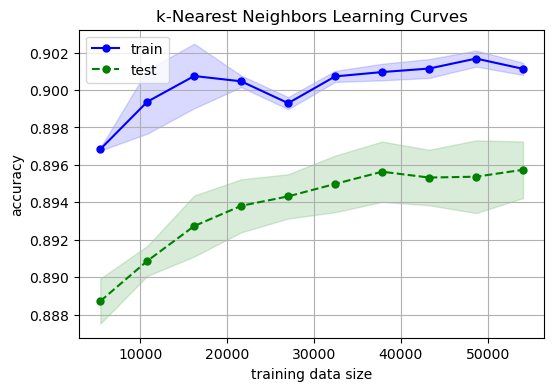

In [43]:
# generate different set sizes and get scores
train_sizes, train_scores, test_scores = learning_curve(KNeighborsClassifier(n_neighbors=25, p=1),
                                                        X_train, y_train,
                                                        train_sizes=np.linspace(0.1, 1.0, 10)
                                                       )

plot_learning_curves(clf='k-Nearest Neighbors')

In [44]:
knn = KNeighborsClassifier(n_neighbors=25, p=1)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)

# make predictions
y_pred_knn = knn.predict(test)

# evaluation metrics
acc_knn = metrics.accuracy_score(y_test, knn_pred)
kappa_knn = metrics.cohen_kappa_score(y_test, knn_pred)

print("Accuracy: {:0.4f}\nCohen's kappa: {:0.4f}".format(acc_knn, kappa_knn))

Accuracy: 0.9018
Cohen's kappa: 0.8205


In [45]:
# extract predicted classes, colors, covers
knn_classes = np.unique(y_pred_knn).tolist()
knn_colors = df_esa.query(f'Class in {knn_classes}')['Hex'].tolist()
knn_covers = df_esa.query(f'Class in {knn_classes}')['Cover'].tolist()

# new array made of assigned color indices to predicted labels
knn_func = np.vectorize(lambda x: knn_classes.index(x))
knn_data = knn_func(y_pred_knn)

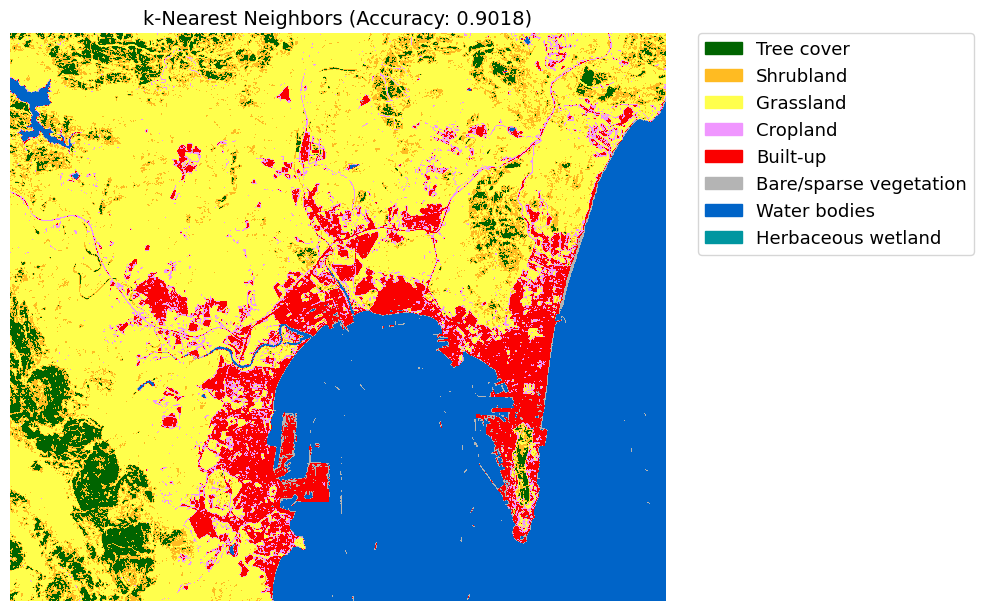

In [46]:
knn_cmap = ListedColormap(knn_colors)

height = ds_testing.ReadAsArray().shape[2]
width = ds_testing.ReadAsArray().shape[1]

# plot predicted data
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(knn_data.reshape(height, width).T, cmap=knn_cmap, vmin=0, vmax=len(knn_colors)-1)

ep.draw_legend(im_ax=im, classes=knn_classes, titles=knn_covers)
#ax.set_title('k-Nearest Neighbors (Accuracy: {:.2f}%)'.format(acc_knn*100), fontsize=14)
ax.set_title('k-Nearest Neighbors (Accuracy: {:.4f})'.format(acc_knn), fontsize=14)
ax.set_axis_off()

# auto adjust plot to fit figure size
plt.tight_layout()
plt.show()

In [47]:
print(metrics.classification_report(y_test, knn_pred, target_names=cover_labels))

                        precision    recall  f1-score   support

            Tree cover       0.75      0.59      0.66      1801
             Shrubland       0.54      0.48      0.51       462
             Grassland       0.68      0.78      0.73      3173
              Cropland       0.42      0.11      0.17       120
              Built-up       0.79      0.89      0.84      4296
Bare/sparse vegetation       0.66      0.23      0.34       422
          Water bodies       1.00      0.99      0.99     18646
    Herbaceous wetland       0.29      0.04      0.07        48

              accuracy                           0.90     28968
             macro avg       0.64      0.51      0.54     28968
          weighted avg       0.90      0.90      0.90     28968



**5.4. Random Forest**

In [48]:
# hyperparameter tuning
n_estimators = [100, 150, 200]
max_depth_values = [None, 2, 3, 4, 5]

rf_scores = []

for depth in max_depth_values:
    for n in n_estimators:
        rf = RandomForestClassifier(max_depth=depth, n_estimators=n)
        rf.fit(X_train, y_train)
        rf_pred = rf.predict(X_test)
        
        rf_scores.append({'accuracy': metrics.accuracy_score(y_test, rf_pred),
                          'max_depth': depth,
                          'n_estimators': n,
                         })

# get optimum hyperparameters
accuracies = [result['accuracy'] for result in rf_scores]
rf_idx = accuracies.index(max(accuracies))

print('Best score:', rf_scores[rf_idx])

Best score: {'accuracy': 0.9021333885666943, 'max_depth': None, 'n_estimators': 200}


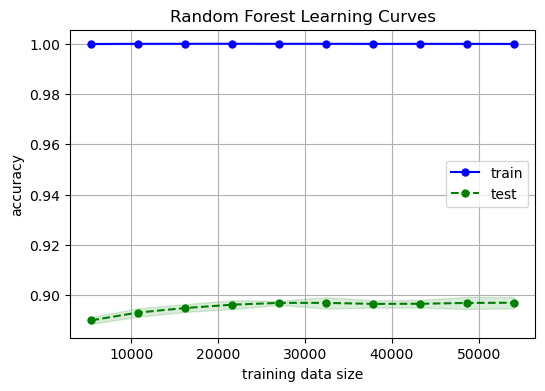

In [49]:
# generate different set sizes and get scores
train_sizes, train_scores, test_scores = learning_curve(RandomForestClassifier(max_depth=None, n_estimators=200),
                                                        X_train, y_train,
                                                        train_sizes=np.linspace(0.1, 1.0, 10)
                                                       )

plot_learning_curves(clf='Random Forest')

In [50]:
rf = RandomForestClassifier(max_depth=None, n_estimators=200)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

# make predictions
y_pred_rf = rf.predict(test)

# evaluation metrics
acc_rf = metrics.accuracy_score(y_test, rf_pred)
kappa_rf = metrics.cohen_kappa_score(y_test, rf_pred)

print("Accuracy: {:0.4f}\nCohen's kappa: {:0.4f}".format(acc_rf, kappa_rf))

Accuracy: 0.9027
Cohen's kappa: 0.8218


In [51]:
# extract predicted classes, colors, covers
rf_classes = np.unique(y_pred_rf).tolist()
rf_colors = df_esa.query(f'Class in {rf_classes}')['Hex'].tolist()
rf_covers = df_esa.query(f'Class in {rf_classes}')['Cover'].tolist()

# new array made of assigned color indices to predicted labels
rf_func = np.vectorize(lambda x: rf_classes.index(x))
rf_data = rf_func(y_pred_rf)

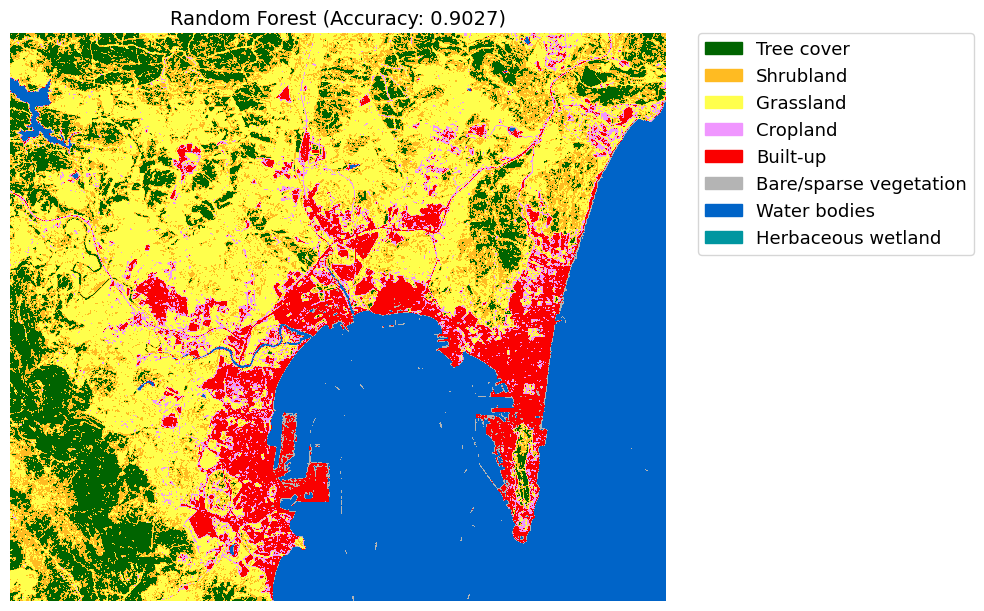

In [52]:
rf_cmap = ListedColormap(rf_colors)

height = ds_testing.ReadAsArray().shape[2]
width = ds_testing.ReadAsArray().shape[1]

# plot predicted data
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(rf_data.reshape(height, width).T, cmap=rf_cmap, vmin=0, vmax=len(rf_colors)-1)

ep.draw_legend(im_ax=im, classes=rf_classes, titles=rf_covers)
#ax.set_title('Random Forest (Accuracy: {:.2f}%)'.format(acc_rf*100), fontsize=14)
ax.set_title('Random Forest (Accuracy: {:.4f})'.format(acc_rf), fontsize=14)
ax.set_axis_off()

# auto adjust plot to fit figure size
plt.tight_layout()
plt.show()

In [53]:
print(metrics.classification_report(y_test, rf_pred, target_names=cover_labels))

                        precision    recall  f1-score   support

            Tree cover       0.74      0.64      0.69      1801
             Shrubland       0.59      0.55      0.57       462
             Grassland       0.70      0.74      0.72      3173
              Cropland       0.28      0.09      0.14       120
              Built-up       0.79      0.89      0.84      4296
Bare/sparse vegetation       0.66      0.22      0.33       422
          Water bodies       0.99      0.99      0.99     18646
    Herbaceous wetland       0.16      0.06      0.09        48

              accuracy                           0.90     28968
             macro avg       0.61      0.52      0.54     28968
          weighted avg       0.90      0.90      0.90     28968



**5.5. Classifier Comparison**

To make the comparison much readable, we will display them in tabular form. A calculation of predicted land covers in percentage will be performed.

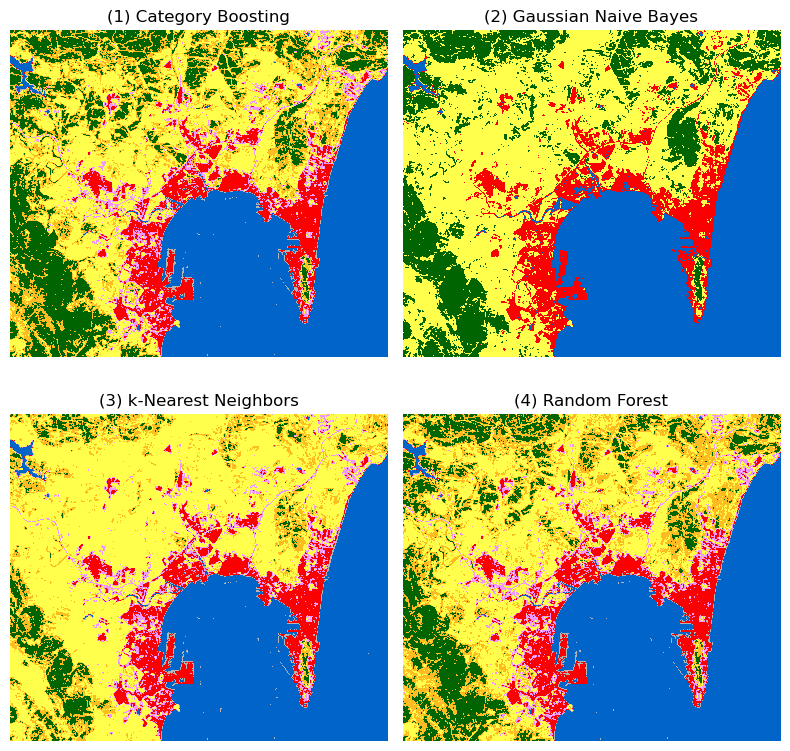

In [54]:
# visualize all figures in one
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

axs[0, 0].imshow(cb_data.reshape(height, width).T, cmap=cb_cmap, vmin=0, vmax=len(cb_colors)-1)
axs[0, 0].set_title('(1) Category Boosting')
axs[0, 0].set_axis_off()

axs[0, 1].imshow(nb_data.reshape(height, width).T, cmap=nb_cmap, vmin=0, vmax=len(nb_colors)-1)
axs[0, 1].set_title('(2) Gaussian Naive Bayes')
axs[0, 1].set_axis_off()

axs[1, 0].imshow(knn_data.reshape(height, width).T, cmap=knn_cmap, vmin=0, vmax=len(knn_colors)-1)
axs[1, 0].set_title('(3) k-Nearest Neighbors')
axs[1, 0].set_axis_off()

axs[1, 1].imshow(rf_data.reshape(height, width).T, cmap=rf_cmap, vmin=0, vmax=len(rf_colors)-1)
axs[1, 1].set_title('(4) Random Forest')
axs[1, 1].set_axis_off()

plt.tight_layout()
plt.show()

All four demonstrated classifiers performed properly. They are able to correctly predict permanent water bodies, urban areas, and forests. The most details are visible for both category boosting and random forest, which had practically the same performance in terms of metrics. The Naive Bayes model performed a very generalized prediction with only four main covers. This classifier would be a great choice for small scale images or maps, in which a very large area has small amount of detail. The k-nearest neighbors predicted the least amount of tree cover and shrubland with the great advantage of grassland.

In [55]:
# evaluation metrics
pd.DataFrame([[acc_cb, acc_nb, acc_knn, acc_rf],
              [kappa_cb, kappa_nb, kappa_knn, kappa_rf]],
             index=['Accuracy', "Cohen's kappa"],
             columns=['CatBoost', 'GaussianNB', 'k-Nearest Neighbors', 'RandomForest']).round(4)

CatBoost  GaussianNB  k-Nearest Neighbors  RandomForest
Accuracy         0.9049      0.8668               0.9018        0.9027
Cohen's kappa    0.8258      0.7514               0.8205        0.8218

In [56]:
# testing image resolution
img_res = height * width

# function for cover areas in %
def count_areas(lst, pred):
    unique, counts = np.unique(pred, return_counts=True)
    for i in counts:
        lst.append((100 * i)/img_res)
    #lst.append(sum(lst))
    
cb_areas = []
nb_areas = []
knn_areas = []
rf_areas = []

list_area = [cb_areas, nb_areas, knn_areas, rf_areas]
list_pred = [y_pred_cb, y_pred_nb, y_pred_knn, y_pred_rf]

for i, j in zip(list_area, list_pred):
    count_areas(lst=i, pred=j)

# insert missing covers for GaussianNB list
nb_areas.insert(1, 0)
nb_areas.insert(3, 0)
nb_areas.insert(5, 0)
nb_areas.insert(7, 0)

In [57]:
# percentage of covers for each classifier
pd.DataFrame([cb_areas, nb_areas, knn_areas, rf_areas],
             index=['CatBoost', 'GaussianNB', 'k-Nearest Neighbors', 'RandomForest'],
             columns=cover_labels).round(2)

Tree cover  Shrubland  Grassland  Cropland  Built-up   
CatBoost                  19.50       0.01      37.76      0.03     12.51  \
GaussianNB                13.37       0.00      45.23      0.00     10.92   
k-Nearest Neighbors        7.00       0.22      50.92      0.01     11.82   
RandomForest              16.77       0.01      40.11      0.03     12.89   

                     Bare/sparse vegetation  Water bodies  Herbaceous wetland  
CatBoost                               0.32         29.83                0.05  
GaussianNB                             0.00         30.48                0.00  
k-Nearest Neighbors                    0.35         29.68                0.00  
RandomForest                           0.30         29.82                0.07

### 6. Conclusions

This notebook was conducted to examine the accuracy of different machine-learning classifiers for LULC mapping for satellite images. The aim was to suggest the best classifier. Four popular machine-learning algorithms were applied on the Sentinel-2 data for the LULC classification. Empirical evaluation assessments were undertaken by using accuracy and the Kappa coefficient. Results suggest that the closest classifications were performed by category boosting and random forests. The mapping results of the Naive Bayes model are very generalized, yet still capable to properly classify the major land covers (permanent water bodies, grasslands, built-ups). To justify the final result, both category boosting and random forests are the best classifiers for LULC modelling on this area. The study proves machine-learning techniques to be very useful and accurate for land-cover tasks in remote sensing.

**References:**

* A.M. Abdi, 2019, *Land cover and land use classification performance of machine learning algorithms in a boreal landscape using Sentinel-2 data*, [Full Text](https://www.tandfonline.com/doi/full/10.1080/15481603.2019.1650447)
* B.E. Taiwo, A. - Al Kafy, A.A Samuel, Z.A. Rahaman, O.E. Ayowole, M. Shahrier, B. Monowar Duti, M.T. Rahman, O.T. Peter, O.O. Abosede, 2023, *Monitoring and predicting the influences of land use/land cover change on cropland characteristics and drought severity using remote sensing techniques*, [Full Text](https://www.sciencedirect.com/science/article/pii/S2665972723000259)
* S. Talukdar, P. Singha, S. Mahato, Shahfahad, S. Pal, Yuei-An Liou, A. Rahman, 2020, *Land-Use Land-Cover Classification by Machine Learning Classifiers for Satellite Observations—A Review*, [Full Text](https://www.mdpi.com/2072-4292/12/7/1135)
* *ESA WorldCover Product User Manual v2.0*, 2022, [Manual](https://esa-worldcover.s3.eu-central-1.amazonaws.com/v200/2021/docs/WorldCover_PUM_V2.0.pdf)
* https://gisgeography.com/sentinel-2-bands-combinations/ [Accessed: 23.07.2024]
* https://towardsdatascience.com/land-cover-classification-in-satellite-imagery-using-python-ae39dbf2929 [Accessed: 23.07.2024]